In [1]:
import pandas as pd
from pandas import Series
import numpy as np
import scipy
from datetime import datetime, timedelta

# Forceasting with decompasable model
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# For marchine Learning Approach
from statsmodels.tsa.tsatools import lagmat
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error 
from math import sqrt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt 
import statsmodels.api as sm 

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import warnings                   
warnings.filterwarnings("ignore")

In [2]:
#Importing data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

train_original=train.copy() 
test_original=test.copy()

In [3]:
train.columns, test.columns

(Index(['ID', 'Datetime', 'Count'], dtype='object'),
 Index(['ID', 'Datetime'], dtype='object'))

In [4]:
train.head(10)

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2
5,5,25-08-2012 05:00,2
6,6,25-08-2012 06:00,2
7,7,25-08-2012 07:00,2
8,8,25-08-2012 08:00,6
9,9,25-08-2012 09:00,2


In [5]:
train['Datetime'] = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
test['Datetime'] = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 

test_original['Datetime'] = pd.to_datetime(test_original.Datetime,format='%d-%m-%Y %H:%M') 
train_original['Datetime'] = pd.to_datetime(train_original.Datetime,format='%d-%m-%Y %H:%M')

In [6]:
#for i in (train, test):
for i in (train, test, test_original, train_original):
    i['year']=i.Datetime.dt.year 
    i['month']=i.Datetime.dt.month 
    i['day']=i.Datetime.dt.day
    i['Hour']=i.Datetime.dt.hour 

In [7]:
train['day of week']=train['Datetime'].dt.dayofweek 
temp = train['Datetime']

In [8]:
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0 
temp2 = train['Datetime'].apply(applyer) 
train['weekend']=temp2

In [9]:
train.index = train['Datetime']
df = train.drop('ID',1)

Text(0, 0.5, 'Count')

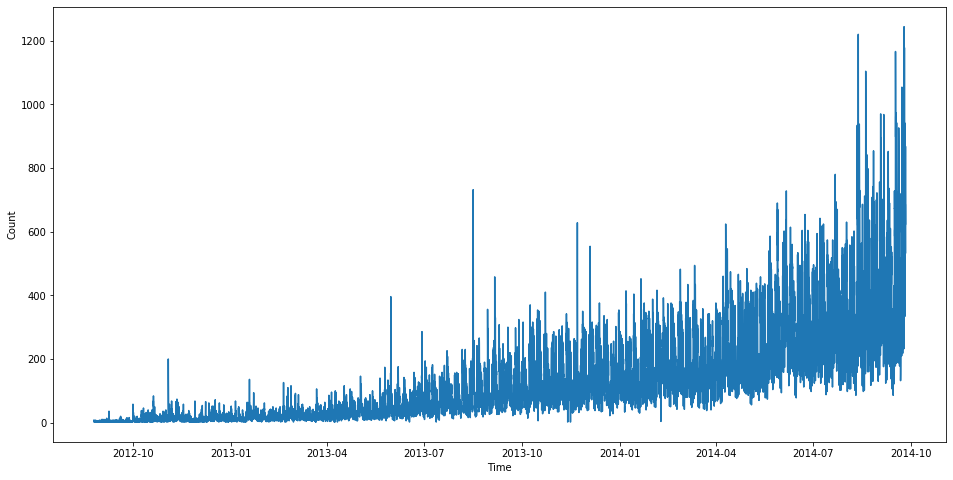

In [10]:
ts = df['Count']

plt.figure(figsize=(16,8)) 
plt.plot(ts)
plt.xlabel('Time')
plt.ylabel('Count') 

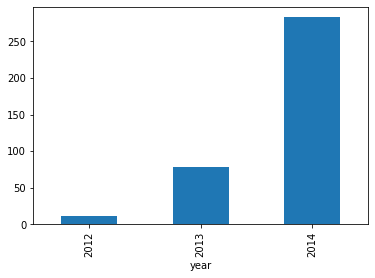

In [11]:
train.groupby('year')['Count'].mean().plot.bar()

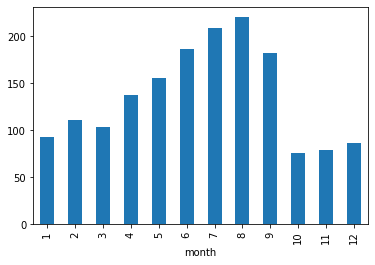

In [12]:
train.groupby('month')['Count'].mean().plot.bar()

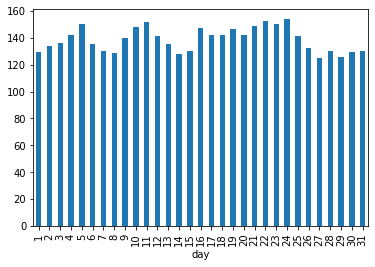

In [13]:
train.groupby('day')['Count'].mean().plot.bar()

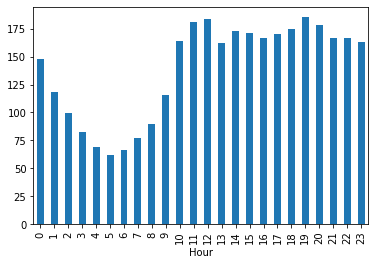

In [14]:
train.groupby('Hour')['Count'].mean().plot.bar()

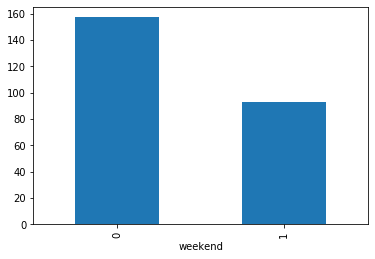

In [15]:
train.groupby('weekend')['Count'].mean().plot.bar()

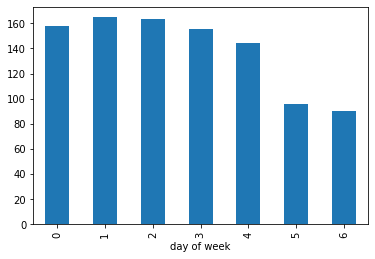

In [16]:
train.groupby('day of week')['Count'].mean().plot.bar()

In [17]:
train = train.drop('ID',1)
train.Timestamp = pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
train.index = train.Timestamp 

In [18]:
hourly = train.resample('H').mean() 
daily = train.resample('D').mean() 
weekly = train.resample('W').mean() 
monthly = train.resample('M').mean()

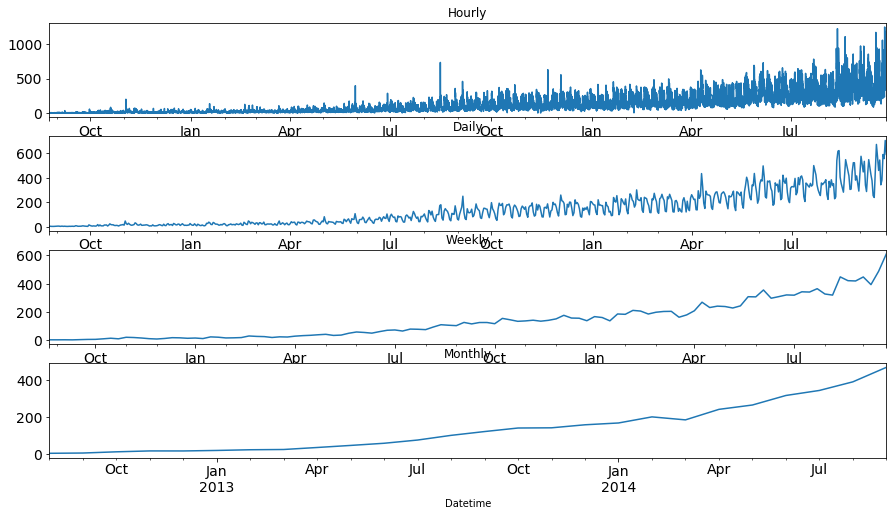

In [19]:
fig, axs = plt.subplots(4,1) 
hourly.Count.plot(figsize=(15,8), title= 'Hourly', fontsize=14, ax=axs[0]) 
daily.Count.plot(figsize=(15,8), title= 'Daily', fontsize=14, ax=axs[1]) 
weekly.Count.plot(figsize=(15,8), title= 'Weekly', fontsize=14, ax=axs[2]) 
monthly.Count.plot(figsize=(15,8), title= 'Monthly', fontsize=14, ax=axs[3]) 

In [20]:
test.Timestamp = pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M')
test.index = test.Timestamp
test = test.resample('D').mean()

In [21]:
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 
train = train.resample('D').mean()

### Split data into training and validation

In [22]:
Train = train['2012-08-25':'2014-06-24'] 
valid = train['2014-06-25':'2014-09-25']

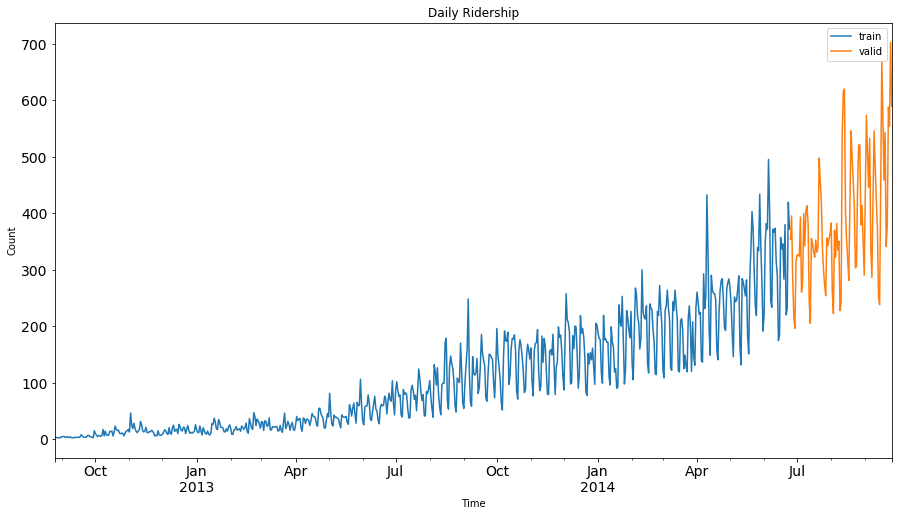

In [23]:
Train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='train') 
valid.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='valid') 

plt.xlabel('Time') 
plt.ylabel('Count') 
plt.legend(loc='best') 
plt.show()

### Exponential Smoothing Model

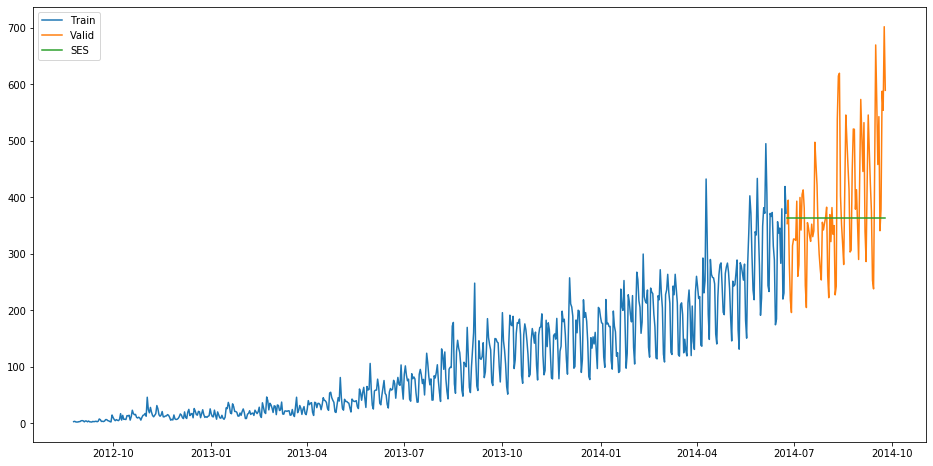

rms = 113.43708111884514


In [24]:
y_hat_avg = valid.copy() 
fit2 = SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level=0.6,optimized=False) 
y_hat_avg['SES'] = fit2.forecast(len(valid)) 
plt.figure(figsize=(16,8)) 
plt.plot(Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['SES'], label='SES') 
plt.legend(loc='best') 
plt.show()

rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.SES)) 
print('rms =', rms)

### Hourly Ratio

In [25]:
submission = pd.read_csv("data/sample_submission.csv")

In [26]:
train_original['ratio']=train_original['Count']/train_original['Count'].sum() 
temp = train_original.groupby(['Hour'])['ratio'].sum() 
pd.DataFrame(temp, columns=['Hour','ratio']).to_csv('GROUPby.csv') 

In [27]:
temp2 = pd.read_csv("GROUPby.csv") 
temp2 = temp2.drop('Hour.1',1) 

### Holt Winters Model

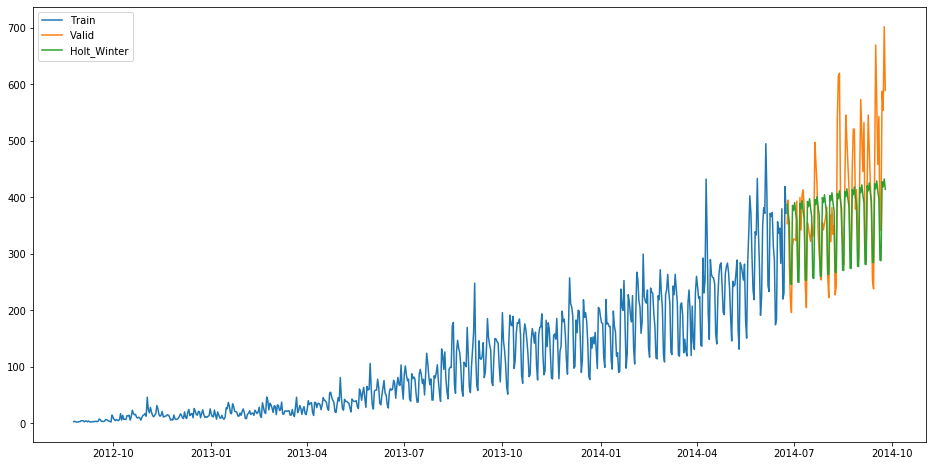

rms = 82.37571191747172


In [28]:
y_hat_avg = valid.copy() 
fit1 = ExponentialSmoothing(np.asarray(Train['Count']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit() 
y_hat_avg['Holt_Winter'] = fit1.forecast(len(valid)) 
plt.figure(figsize=(16,8)) 
plt.plot( Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter') 
plt.legend(loc='best') 
plt.show()

rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt_Winter)) 
print('rms =', rms)

In [29]:
predict=fit1.forecast(len(test))
test['prediction']=predict

merge=pd.merge(test, test_original, on=('day','month', 'year'), how='left') 
merge['Hour']=merge['Hour_y'] 
merge=merge.drop(['year', 'month', 'Datetime','Hour_x','Hour_y'], axis=1) 

prediction=pd.merge(merge, temp2, on='Hour', how='left') 
prediction['Count']=prediction['prediction']*prediction['ratio']*24
prediction['ID']=prediction['ID_y'] 

submission=prediction.drop(['day','Hour','ratio','prediction', 'ID_x', 'ID_y'],axis=1) 
pd.DataFrame(submission, columns=['ID','Count']).to_csv('Holt winters.csv')

### SARIMAX Model

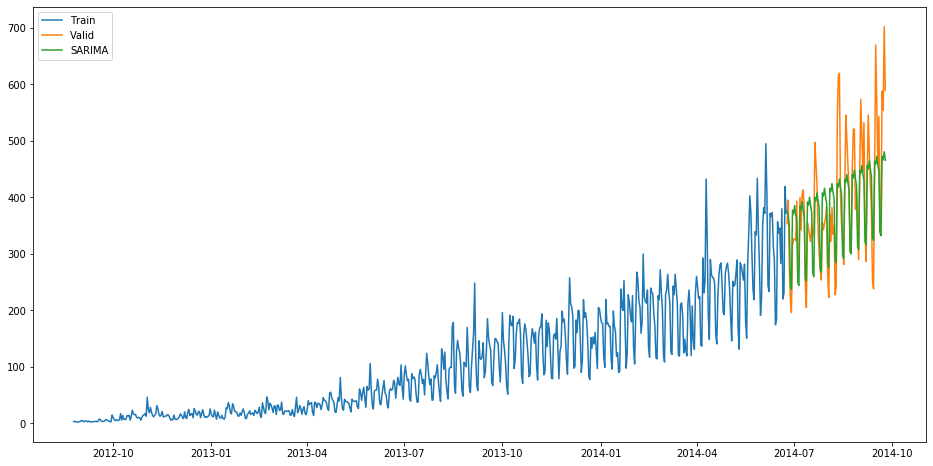

rms = 69.88508448051837


In [30]:
import statsmodels.api as sm
y_hat_avg = valid.copy() 
fit1 = sm.tsa.statespace.SARIMAX(Train.Count, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit() 
y_hat_avg['SARIMA'] = fit1.predict(start="2014-6-25", end="2014-9-25", dynamic=True) 
plt.figure(figsize=(16,8)) 
plt.plot( Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['SARIMA'], label='SARIMA') 
plt.legend(loc='best') 
plt.show()

rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.SARIMA)) 
print('rms =', rms)

In [31]:
predict=fit1.predict(start="2014-9-26", end="2015-4-26", dynamic=True)
test['prediction']=predict

merge=pd.merge(test, test_original, on=('day','month', 'year'), how='left') 
merge['Hour']=merge['Hour_y'] 
merge=merge.drop(['year', 'month', 'Datetime','Hour_x','Hour_y'], axis=1) 

prediction=pd.merge(merge, temp2, on='Hour', how='left') 
prediction['Count']=prediction['prediction']*prediction['ratio']*24
prediction['ID']=prediction['ID_y'] 

submission=prediction.drop(['day','Hour','ratio','prediction', 'ID_x', 'ID_y'],axis=1) 
pd.DataFrame(submission, columns=['ID','Count']).to_csv('SARIMAX.csv')